# Segmentez des clients d'un site e-commerce - *Notebook simulation*

In [34]:
import numpy as np

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import scipy
from scipy import stats
import scipy.stats as st

import statsmodels
import statsmodels.api as sm
import missingno as msno

import sklearn

from sklearn.impute import KNNImputer
from category_encoders.ordinal import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from category_encoders import TargetEncoder

# pour le centrage et la réduction
from sklearn.preprocessing import StandardScaler
# pour l'ACP
from sklearn.decomposition import PCA

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.datasets import make_blobs

from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier

from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

from sklearn.manifold import TSNE

from sklearn.utils import resample

from yellowbrick.cluster import KElbowVisualizer

from scipy.cluster.hierarchy import dendrogram, linkage

import timeit
import warnings

# pour cartographie
import folium
import cartopy.crs as ccrs
import geopandas as gpd
import contextily as ctx

import sqlite3

print("numpy version", np.__version__)
print("pandas version", pd.__version__)
print("matplotlib version", matplotlib.__version__)
print("seaborn version", sns.__version__)
print("scipy version", scipy.__version__)
print("statsmodels version", statsmodels.__version__)
print("missingno version", msno.__version__)

print("sklearn version", sklearn.__version__)

print("folium version", folium.__version__)

pd.options.display.max_rows = 200
pd.options.display.max_columns = 100

numpy version 1.26.4
pandas version 2.1.4
matplotlib version 3.8.0
seaborn version 0.13.2
scipy version 1.11.4
statsmodels version 0.14.0
missingno version 0.5.2
sklearn version 1.2.2
folium version 0.19.2


## 1 - Démarche

J'utiliserais les mêmes features que celles utilisées dans le 2ème essai; c'est à dire :
- récence
- fréquence
- montant
- score_moyen

Voici les étapes :
- **T0 :** entraînement initial du modèle M0 sur le dataset X_0, créé à partir de toutes les commandes passées jusqu’à T0.
    - L'entraînement de ce modème génére la liste des clusters C0=M0.fit_predict(X_0).
- **T1 :**  entrainement du nouveau modème M1 sur le dataset X_1, créé à partir de toutes les commandes passées jusqu’à T1.
    - L'entraînement de ce modème génére la liste des clusters C1_new=M1.fit_predict(X_1).
    - On fait ensuite une nouvelle prédiction avec M0 sur M1 ==> C1_init = M0.predict(X_1).
    - On calcule l'ARI entre C1 et C1_init avec adjusted_rand_score avec sklearn.
- **T2 :**  entrainement du nouveau modème M2 sur le dataset X_2, créé à partir de toutes les commandes passées jusqu’à T2.
    - L'entraînement de ce modème génére la liste des clusters C2_new=M2.fit_predict(X_2).
    - On fait ensuite une nouvelle prédiction avec M0 sur M2 ==> C2_init = M0.predict(X_2).
    - On calcule l'ARI entre C2_new et C2_init avec adjusted_rand_score avec sklearn.         

## 2 - Création d'une fonction d'extraction du jeu de données par date Ti

J'utilise un accès direct à la base de données olist.db.

La fonction créée pour extraire les données de la base prends le paramètre date_select (T0, T1, T2,...).

Les données extraites sont chargées dans un dataframe.

In [68]:
def get_olist_data_per_order_purchase_timestamp(maxDate):

    """
    Récupère les données agrégées des commandes à une date spécifiée à partir de la base de données Olist.

    Cette fonction exécute une requête SQL pour calculer les métriques RFM (Récence, Fréquence, Montant) 
    ainsi que le score moyen des avis clients pour chaque client unique, en utilisant une date d'achat 
    maximale comme référence. Elle retourne un DataFrame contenant ces métriques agrégées.

    Args:
        maxDate (str): La date et l'heure maximale pour les commandes à analyser, au format 
                       'YYYY-MM-DD HH:MM:SS'.

    Returns:
        pandas.DataFrame: Un DataFrame avec les colonnes suivantes pour chaque client unique :
            - recence (int): Nombre de jours depuis la dernière commande.
            - frequence (int): Nombre de commandes distinctes passées par le client.
            - montant (float): Montant total dépensé par le client.
            - score_moyen (float): Note moyenne des avis donnés par le client.

    Raises:
        sqlite3.OperationalError: Si une erreur survient lors de l'exécution de la requête SQL.
        sqlite3.ProgrammingError: Si les paramètres de la requête ne correspondent pas au nombre attendu.

    Example:
        >>> df = get_olist_data_per_order_purchase_timestamp("2018-10-17 17:30:18")
        >>> print(df.head())

    Notes:
        - Cette fonction utilise SQLite pour interagir avec la base de données.
        - La connexion à la base de données est fermée après l'exécution.
        - La colonne "customer_unique_id" est exclue du DataFrame retourné.
    """
    
    # Connexion à une base SQLite (ou création si elle n'existe pas)
    conn = sqlite3.connect('C:/Users/admin/Documents/Projets/Projet_5/olist.db')
    
    # Créer un curseur
    cursor = conn.cursor()

    # Requête SQL
    query = """
                    WITH orders_join_rfm AS(
                    	SELECT c.customer_unique_id,
                    	       CAST(julianday(:maxDate) - julianday(MAX(o.order_purchase_timestamp)) AS INTEGER) AS recence,
                        	   COUNT(DISTINCT o.order_id) AS frequence,
                        	   SUM(oi.price) AS montant
                    	    FROM customers c
                    	    LEFT JOIN orders o ON c.customer_id = o.customer_id
                    	    LEFT JOIN order_items oi ON o.order_id = oi.order_id
                    		GROUP BY c.customer_unique_id
                    ),
                    review_joins AS(
                    	SELECT c.customer_unique_id, AVG(or2.review_score) AS score_moyen
                    		FROM customers c
                    		INNER JOIN orders o ON o.customer_id = c.customer_id
                    		INNER JOIN order_reviews or2 ON or2.order_id = o.order_id
                    		GROUP BY c.customer_unique_id 
                    ),
                    aggregation AS(
                    	SELECT orfm.customer_unique_id, recence, frequence, montant, score_moyen
                    		FROM orders_join_rfm orfm
                    		LEFT JOIN review_joins rj ON rj.customer_unique_id = orfm.customer_unique_id
                    )
                    SELECT * 
                    	FROM aggregation
            """         

    # Exécution avec paramètre pour maxDate
    cursor.execute(query, {'maxDate': maxDate})
    rows = cursor.fetchall()

    # Fermer la connexion
    conn.close()
    
    # Obtenir les noms de colonnes
    columns = [description[0] for description in cursor.description]

    # Convertir en DataFrame
    df = pd.DataFrame(rows, columns=["customer_unique_id", "recence", "frequence", "montant", "score_moyen"])
    df.drop('customer_unique_id', axis=1, inplace=True)    
    
    return df

Testons la fonction :

In [70]:
df = get_olist_data_per_order_purchase_timestamp("2018-10-17 17:30:18")

df.head()

,recence,frequence,montant,score_moyen
0,160,1,129.90,5.0
1,163,1,18.90,4.0
2,585,1,69.00,3.0
3,369,1,25.99,4.0
4,336,1,180.00,5.0


In [61]:
df.shape

(96096, 4)

## 3 - Création des fonctions de transformation et d'affichage

### 3.1 - Création d'une fonction de transformation des données



### 3.2 - Création d'une fonction d'affichage des distributions

In [64]:
def print_features_distribution(df):
    # Créer des histogrammes pour chaque colonne
    fig = plt.figure(figsize=(14, 10))
    for feat_idx in range(df.shape[1]):  # Pour chaque colonne
        ax = fig.add_subplot(3, 4, feat_idx + 1)  # Ajouter à la grille
        h = ax.hist(df.iloc[:, feat_idx], bins=50, color="steelblue", edgecolor="none")
        ax.set_title(df.columns[feat_idx], fontsize=14)
    
    plt.tight_layout()
    plt.show()

Testons la fonction :

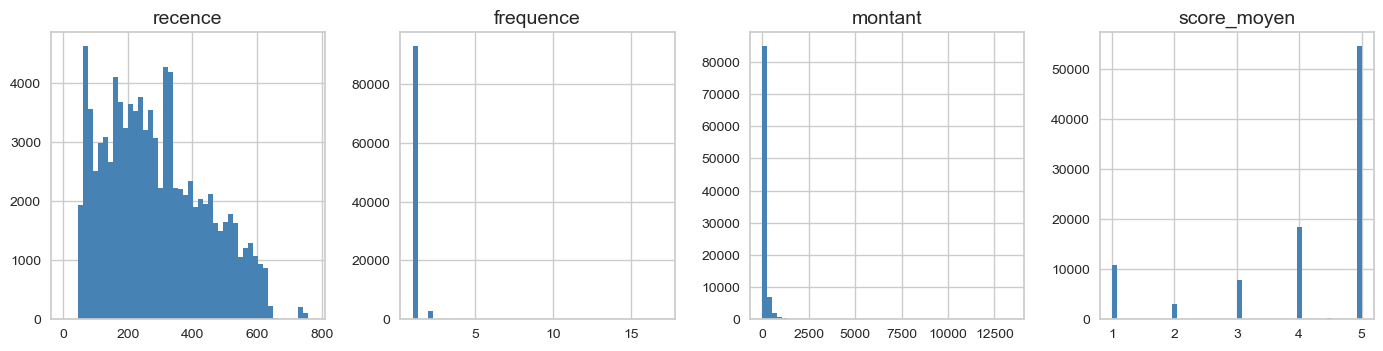

In [72]:
print_features_distribution(df)